In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
from meshmaker.vec3 import vec3
from meshmaker.quat import quat
from meshmaker.tform import tform
from meshmaker.field import scalar_field, height_field, vec3_field, trace_field
from meshmaker.mesh import planargraph, trimesh
from meshmaker.geometry import slide, sintsxyp, bbox, subdivide_triangles, loop_normal, loop_exterior, loop_split, loop_smooth, loop_contract, loop_area, periodic, isnear
from meshmaker.lsystem import lsystem
from meshmaker.img import perlin, proximal, normalize, segment_regions, steepness
from meshmaker.plt import plot, plot_pg, plot_loop, plot_edges, plot_edge, plot_point
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from functools import partial, reduce

In [3]:
def loop_equal(loop1, loop2):
    return vec3.com(loop1).isnear(vec3.com(loop2)) and len(loop1) == len(loop2)

In [11]:
from meshmaker.geometry import loop_contains

class loop_tree:
    
    @classmethod
    def bloops(cls, b, loops, loop_kws=None):
        t = cls(b)
        for i in range(len(loops)):
            loop = loops[i]
            kws = {} if loop_kws is None else loop_kws[i]
            t.av(loop, **kws)
        return t

    @property
    def piecewise_field(self):
        return lambda p: self.fp(p).field(p)

    @property
    def depth(self):
        d = 0
        p = self.parent
        while p is not None:
            d += 1
            p = p.parent
        return d
    
    def __init__(self, loop, parent=None, **kws):
        self.loop = loop
        self.parent = parent
        self.children = []
        if self.parent is not None:
            self.parent.children.append(self)
        for key, value in kws.items():
            setattr(self, key, value)
                
    def av(self, loop, **kws):
        if self.loop is not None and loop_equal(self.loop, loop):
            return loop_tree(loop, self, **kws)
        elif self.loop is None or loop_contains(self.loop, loop):
            for c in self.children:
                nv = c.av(loop, **kws)
                if nv is not None:
                    return nv
            else:
                return loop_tree(loop, self, **kws)

    def fp(self, p):
        """return most childish loop_tree which properly contains p"""
        if self.loop is None or p.inbxy(self.loop, ie=True):
            for c in self.children:
                if p.inbxy(c.loop, ie=True):
                    return c.fp(p)
            else:
                return self
            
    def plot(self, ax, depth=2):
        linewidth = (self.depth + 1) * 2
        color = 'k' if self.depth % 2 == 0 else 'b'
        plot_loop(ax, self.loop, lw=linewidth, col=color, mk='')
        for c in self.children:
            c.plot(ax, depth + 2)

In [ ]:
def piecewise_field(loops, fields):    
    loop_kws = [dict(field=fd) for fd in fields]
    lt = loop_tree(loops.pop(0))
    lt = loop_tree.bloops(None, loops, loop_kws=loop_kws)
    def eigen(p):
        return lt.fp(p).field(p)
    return eigen

pwf = piecewise_field([vec3.O().ring(10, 8), vec3.O().ring(4, 4)],
                      [scalar_field([lambda p: -1]), scalar_field([lambda p: 1])])

In [ ]:
pwf(vec3.O().set(0, -90, 0))

In [12]:
def plot_vec3_field(ax, fd):
    ps = []
    for x in np.linspace(-500, 500, 21):
        for y in np.linspace(-500, 500, 21):
            ps.append(vec3(x, y, 0))
    a, b = bbox(ps)
    dl = max(b.x - a.x, b.y - a.y) / 100
    for p in ps:
        v = fd(p)
        v.nrmd()
        u = v.crs(vec3.Z())
        u.nrmd()
        plot_point(ax, p)
        plot_edge(ax, p - v * (dl / 1), p + v * (dl / 1), lw=2, col='b')
        plot_edge(ax, p - u * (dl / 1), p + u * (dl / 1), lw=1, col='g')
    _ = 300
    ax.set_xlim((-_, _))
    ax.set_ylim((-_, _))
    return ax

In [13]:
def percentile_mask(a, n=5):
    """set all but the n highest values in a to 0"""
    q = n * 100 / len(a)
    q = min(max(q, 100), 0)
    a[np.where(a < np.percentile(a, q))] = 0
    return a


def distribution(a, n_best=None):
    """get a useful distribution for sampling from a"""
    if n_best is not None:
        a = percentile_mask(a, n=n_best)
    if a.max() == 0:
        a += 1.0
    a /= a.sum()
    return a

In [14]:
class proceduralgraph(planargraph):    
    """a planar graph which can be procedural grown"""

    def __init__(self, fd, *ags, layer=0, **kws):
        super().__init__(*ags, **kws)
        self.fd = fd
        self.layer = layer
    

    @property
    def elements(self):
        """get vec3_field elements which may depend on self"""
        return [self.fd]

    
    def fork_field(self, decay=0.01, weight=1.0, min_order=4):
        """get scalar_field based on vertex path distances to forked intersections"""
        rad = partial(scalar_field.radial, decay=decay, weight=weight)
        es = ((v, self.forkorder(i)) for i, v in enumerate(self.vertices) if v is not None)
        return scalar_field([rad(v, o) for v, o in es if o >= min_order])
        
    
    def get_vertex_weights(self, fd, n_best=None, mask=None, layer=None):
        """get a probability distribution over self.vertices for selection"""
        
        # TODO: MASK BY CURRENT LAYER??
        # TODO: MASK BY CURRENT LAYER??
        # TODO: MASK BY CURRENT LAYER??
        def remask(v):
            if v is None:
                return True
            else:
                layered = (layer is not None and v.properties.get('layer') == layer)
                masked = (mask is not None and mask(v))
                return not (layered and not masked)
                
        remask = lambda v: v is None or (mask is not None and mask(v))

        weights = [(0.0 if remask(v) else fd(v)) for v in self.vertices]
        return distribution(np.array(weights), n_best=n_best)


    def get_vertex_alpha(self, p, c):
        """select alpha value where field points most toward c"""
        f = vec3_field(self.elements)(p).nrm()
        #c = vec3.com(eb)
        best = None
        chosen = 0
        for alpha in (x * (np.pi / 2) for x in range(4)):
            q = p + f.cp().rot(quat.av(alpha, vec3.Z()))
            d = q.dxy(c)
            if best is None or d < best:
                chosen = alpha
                best = d
        return chosen
    
    
    def find_exit(self, eb, decay=0.01, weight=1.0, min_order=4):
        """find optimal existing vertex on eb"""
        mask = (lambda p: not p.onbxy(eb, True))
        field = self.fork_field(decay, weight, min_order)
        weights = self.get_vertex_weights(field, n_best=5, mask=mask, layer=self.layer)
        return np.random.choice(len(weights), p=weights)
    

    def find_tip(self, eb=None, decay=0.01, weight=1.0, min_order=4):
        """find optimal existing vertex optional inside or on eb"""
        mask = None if eb is None else (lambda p: not p.inbxy(eb, True))
        field = self.fork_field(decay, weight, min_order)
        weights = self.get_vertex_weights(field, n_best=5, mask=mask, layer=self.layer)
        return np.random.choice(len(weights), p=weights)
    

    def fork_tips(self, eb=None):
        """yield a sequence of new tips suitable for tracing"""
        s = self.find_tip(eb=eb)
        edges = [((s, o) if (s < o) else (o, s)) for o in self.rings[s]]
        edges = [self.edges[self.edge_lookup[e]] for e in edges]
        alphas = [p.get('alpha', self.get_vertex_alpha(self.vertices[i], vec3.com(eb)) + np.pi / 2)
                  for i, j, p in edges]
        if len(alphas) == 0:
            yield (s, 0)
        elif len(alphas) == 1:
            # TODO: assert alpha which does not force u-turn
            yield (s, alphas[0])
        elif len(alphas) == 2:
            a = abs(alphas[1] - alphas[0])
            if isnear(a, 0) or isnear(a, np.pi):
                b = periodic(0, 2 * np.pi, alphas[0] + np.random.choice((1, 3)) * (np.pi / 2))
                yield (s, b)
                if np.random.random() < 0.5:
                    yield (s, periodic(0, 2 * np.pi, b + np.pi))
            else:
                # TODO: assert alpha which does not force u-turn
                yield (s, np.random.choice(alphas))
        elif len(alphas) == 3:
            # TODO: assert alpha which does not force u-turn
            yield (s, sorted(alphas, key=lambda a: alphas.count(a))[0])
        else:
            print('too many alphas!', alphas)

    
    def trace(self, ds, n, u, alpha, eb=None, ibs=None):
        """trace a sequence of new edges using fields"""
        p = self.vertices[u]        
        for i, q in enumerate(trace_field(self.elements, ds, alpha)(p)):
            if eb is not None and not q.inbxy(eb, False):
                for x, y in slide(eb, 2):
                    ip = sintsxyp(self.vertices[u], q, x, y)
                    if ip is not None:
                        v = self.av(ip, e=(0.9 * ds), layer=self.layer)
                        if v == u:
                            self.vertices[v].trn(ip - self.vertices[v])
                            return v
                        elif v < len(self.vertices) - 1:
                            return -1
                        else:
                            self.ae(u, v, alpha=alpha, layer=self.layer)
                            return v
                else:
                    raise ValueError('should have found intersection!')
            if ibs is not None:
                for ib in ibs:
                    if q.inbxy(ib, True):
                        for x, y in slide(ib, 2):
                            ip = sintsxyp(self.vertices[u], q, x, y)
                            if ip is not None:
                                v = self.av(ip, e=(0.9 * ds), layer=self.layer)
                                if v == u:
                                    self.vertices[v].trn(ip - self.vertices[v])
                                    return v
                                elif v < len(self.vertices) - 1:
                                    return -2
                                else:
                                    self.ae(u, v, alpha=alpha, layer=self.layer)
                                    return v
                        else:
                            raise ValueError('should have found intersection!')
            v = self.av(q, e=(0.9 * ds), layer=self.layer)
            if v == u:
                return -3
            self.ae(u, v, alpha=alpha, layer=self.layer)
            if not v == len(self.vertices) - 1:
                return -4
            u = v
            if i == n - 1:
                break
        return u

        
    def inset(self, eb, ibs, dl=None, tips=None, max_steps=50, fork_prob=0.2, max_depth=3, depth=0):
        """recursively generate a denser graph within eb but outside of ibs"""
        
        if dl is None:
            p, q = bbox(eb)
            dl = (q - p).mag() / 10
        
        n = 10
        ds = dl / n
        
        if tips is None:
            tips = [(self.av(vec3.com(eb)), np.random.choice(4) * (np.pi / 2))]
        else:
            tips = [(self.av(p.cp()), self.get_vertex_alpha(p, vec3.com(eb))) for p in tips]
        
        steps = 0
        with tqdm(total=max_steps, desc='insetting roads') as pbar:
            while tips and steps < max_steps:
                tip, alpha = tips.pop(0)
                newtip = self.trace(ds, n, tip, alpha, eb=eb, ibs=ibs)
                if newtip < 0:
                    #print('end trace: {}'.format(newtip))
                    pass
                else:
                    tips.append((newtip, alpha))
                if np.random.random() < fork_prob or not tips:
                    for newtip in self.fork_tips(eb=eb):
                        tips.append(newtip)
                steps += 1
                pbar.update(1)
        
        if depth < max_depth - 1:
            loops = [[self.vertices[u] for u in l] for l in self.loops()]
            eloop = loops.pop(loop_exterior(loops))        
            for iloop in loops:
                tip = self.find_exit(iloop)
                tips = [(tip, self.get_vertex_alpha(self.vertices[tip], vec3.com(iloop)))]
                self.layer += 1
                self.inset(iloop, ibs, tips, dl, max_steps, fork_prob, max_depth, depth + 1)
                self.layer -= 1

In [41]:
class Config:
    def __init__(config):
        config.seed = 1
        config.origin = vec3.O()
        config.radius = 500
        config.pixels_per_world_unit = 1
        config.sealevel = 0.03
        config.sandlevel = config.sealevel + 0.02
        config.n_cities = 5

config = Config()

In [ ]:
piecewise vec3_field -> trace_field

In [56]:
keeps = {}


def river_field(rim):
    n = len(rim) // 2
    ps = np.random.choice(rim, size=n)
    ds = np.random.randn(n) * 0.0001 + 0.001
    ws = np.ones(n)
    es = [vec3_field.radial(p, d, w) for p, d, w in zip(ps, ds, ws)]
    fd = vec3_field(es)
    return fd


def landmass_field(landmass, terrain):
    es = [
        vec3_field.grid(vec3.O(), vec3.X(), 0.0, 0.01),
        vec3_field.loop(landmass.loop, 0.1, 0.1),
        vec3_field.topography(terrain, 1.0),
    ]
    fd = vec3_field(es)
    return fd


def county_field(county, terrain):
    es = [
        vec3_field.grid(vec3.O(), vec3.Y(), 0.0, 0.1),
        vec3_field.topography(terrain, 0.1),
    ]
    for lake in county.children:
        assert lake.shore
        es.append(vec3_field.loop(lake.loop, 0.001, 0.1))
    fd = vec3_field(es)
    return fd


def first_road_layer(eb, pg, lt):

    mask = None if eb is None else (lambda p: not p.inbxy(eb, True))
    
    field = self.fork_field()
    weights = pg.get_vertex_weights(field, n_best=5, mask=mask)
    tip = np.random.choice(len(weights), p=weights)


def test():
    np.random.seed(config.seed)

    print('generating continent layer')
    rim = config.origin.ring(config.radius - 50, 8)

    pg = proceduralgraph(None, segs=slide(rim, 2))
    rf = river_field(rim)
    lt = loop_tree(rim, field=rf)

    p, q = bbox(rim)
    dl = (q - p).mag() / 10


    print(f'generating river layer (dl: {dl})')
    tips = np.random.choice(rim, size=np.random.randint(2, len(rim) // 2))
    #rf = river_field(rim)
    #pg.fd = river_field(rim)
    pg.fd = lt.piecewise_field
    pg.layer += 1
    pg.inset(rim, (), dl, tips=tips, max_steps=30, fork_prob=0.2, max_depth=1)


    print(f'generating terrain (pg.minlen: {pg.minlen(4)})')
    eloop, loops = pg.polygon()
    for i in range(2):
        loops = [loop_smooth(l, weight=0.5) for l in loops]
    terrain = height_field(config.origin, config.radius, config.pixels_per_world_unit, loops)


    print('generating loop tree layers')
    itow = tform(vec3.U().xy() * -config.radius, None, vec3(2 * config.radius, 2 * config.radius, 0))
    z0, dz = terrain.img.min(), terrain.img.max() - terrain.img.min()


    print('generating the shore lines')
    sealevel = z0 + config.sealevel * dz
    fps, _, _ = segment_regions(terrain.img > sealevel)
    for fp in fps:
        # TODO: SET THIS FIELD TO INLAND APPROPRIATE
        nl = lt.av(itow.transform(fp), layer='shore', field=None)


    print('generating the sand lines')
    sandlevel = z0 + config.sandlevel * dz
    fps, masks, _ = segment_regions(terrain.img > sandlevel)
    for fp in fps:
        # TODO: SET THIS FIELD TO INLAND APPROPRIATE
        nl = lt.av(itow.transform(fp), layer='sand', field=None)


    print('generating the rural lines')
    mask = sum(masks)
    grad = steepness(terrain.img * mask)
    #mask = mask & (grad < (0.5 / np.sqrt(2)))
    mask = mask & (grad < np.percentile(grad[mask > 0], 68))
    fps, masks, regions = segment_regions(mask)
    fps, _ = zip(*sorted(zip(fps, regions), key=lambda i: i[1].area, reverse=True))
    for i, fp in enumerate(fps):
        if i < config.n_cities:
            # TODO: SET THIS FIELD TO INLAND APPROPRIATE
            nl = lt.av(itow.transform(fp), layer='rural', field=None)
        else:
            break


    print('generating the urban lines')
    mask = sum(masks)
    grad = steepness(terrain.img * mask)
    #mask = mask & (grad < (0.5 / np.sqrt(2)))
    mask = mask & (grad < np.percentile(grad[mask > 0], 68))
    fps, masks, regions = segment_regions(mask)
    fps, _ = zip(*sorted(zip(fps, regions), key=lambda i: i[1].area, reverse=True))
    for i, fp in enumerate(fps):
        if i < config.n_cities:
            # TODO: SET THIS FIELD TO INLAND APPROPRIATE
            nl = lt.av(itow.transform(fp), layer='urban', field=None)
        else:
            break
    
    
    #print('generating first road layer')
    #first_road_layer(rim, pg, lt)

    #pg.fd = county_field(lt, terrain)
    #pg.inset(rim, (), dl, tips=tips, max_steps=30, fork_prob=0.2, max_depth=1)
    

    print('play for keeps')
    keeps['rim'] = rim
    keeps['sealevel'] = sealevel
    keeps['sandlevel'] = sandlevel
    keeps['terrain'] = terrain
    keeps['pg'] = pg
    keeps['lt'] = lt
    
    return
    
    
    
    keeps['lakes'] = []
    for landmass in lt.children:
        counties = [c for c in landmass.children if not c.layer == 'shore']
        if counties:
            lakes = [c.loop for c in landmass.children if c.layer == 'shore']
            
            keeps['lakes'].extend(lakes)
            
            tips = [vec3.com(c.loop) for c in counties]
            
            print(f'generating landmass road layer (dl: {dl})')
            lmfd = landmass_field(landmass, terrain)
            pg.fd = lmfd
            pg.inset(landmass.loop, lakes, dl / 1.0, tips=tips,
                     max_steps=25, fork_prob=0.2, max_depth=1)
            
            for county in counties:

                tips = [county.loop[0].cp()]

                print(f'generating county road layer (dl: {dl})')
                pg.fd = county_field(county, terrain)
                pg.inset(county.loop, (), dl / 1.0, tips=tips,
                         max_steps=50, fork_prob=0.4, max_depth=1)

            else:
                pg.fd = lmfd
                
        else:
            print('no counties within landmass')
    
    
    f, ax = plot(figsize=(6, 6))
    ax.imshow(terrain.img, origin='lower')
    plt.show()

    f, ax = plot(figsize=(6, 6))
    f.tight_layout()
    
    #plot_vec3_field(ax, pg.fd)

    for i, v in enumerate(pg.vertices):
        if v is not None:
            v.properties['annotation'] = str(v.properties.get('layer'))

    plot_loop(ax, rim, col='r', lw=4, mk='o')
    ax.fill([p.x for p in rim], [p.y for p in rim], 'b', alpha=0.3)
    
    plot_pg(ax, pg, mk='', lw=2, annotate=False)
    #for fw in loops:
    #    plot_loop(ax, fw, col='b', lw=2, mk='')
    for fw in keeps['lakes']:
        #plot_loop(ax, fw, col='g', lw=4, mk='')
        ax.fill([p.x for p in fw], [p.y for p in fw], 'b', alpha=0.9)
    for fw in keeps['sealine']:
        #plot_loop(ax, fw, col='b', lw=2, mk='')
        ax.fill([p.x for p in fw], [p.y for p in fw], 'y', alpha=0.9)
    for fw in keeps['countyline']:
        plot_loop(ax, fw, col='r', lw=1, mk='')
        ax.fill([p.x for p in fw], [p.y for p in fw], 'g', alpha=0.9)
    if len(tips) > 0:
        for tip in tips:
            plot_point(ax, tip, mk='s', col='g')
    ax.set_xlim((-radius, radius))
    ax.set_ylim((-radius, radius))
    
    
#prun test(terrain)
test()

insetting roads:  40%|████      | 12/30 [00:00<00:00, 95.90it/s]

generating continent layer
generating river layer (dl: 117.5906668388739)


insetting roads: 100%|██████████| 30/30 [00:00<00:00, 32.85it/s]


generating terrain (pg.minlen: 11.759066683887367)
generating loop tree layers
generating the shore lines
generating the sand lines
generating the rural lines
generating the urban lines
play for keeps


<IPython.core.display.Javascript object>


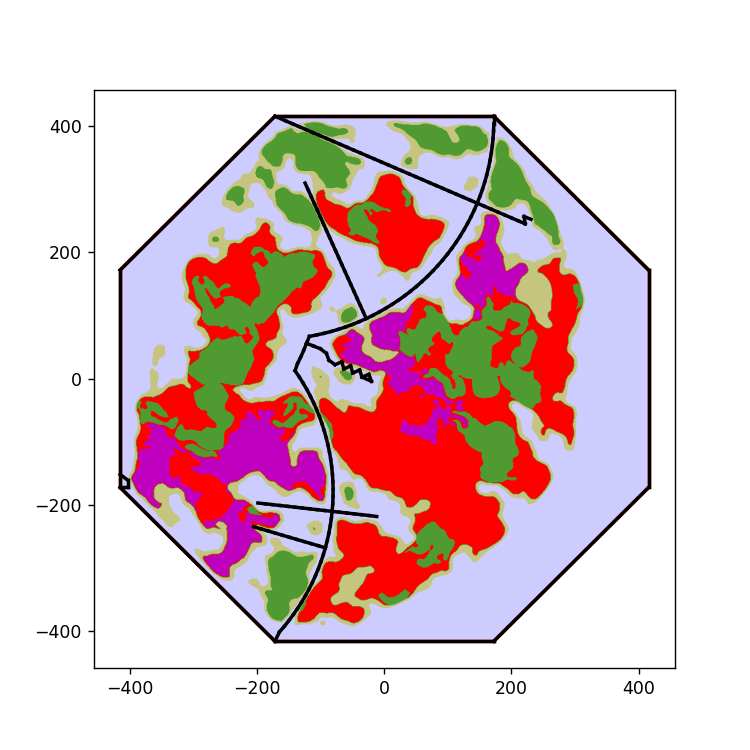

featurelayer rural r
leaturelayer urban m
featurelayer rural r
leaturelayer urban m
featurelayer rural r
leaturelayer urban m
leaturelayer urban m
leaturelayer urban m
featurelayer rural r
featurelayer rural r


In [57]:
def display(pg, lt):
    #f, ax = plot(figsize=(6, 6))
    #lt.plot(ax)
    
    f, ax = plot(figsize=(6, 6))
    
    #lt.plot(ax)
    #return

    colors = dict(shore='y', sand='g', rural='r', urban='m')
    
    rim = lt.loop
    ax.fill([p.x for p in rim], [p.y for p in rim], 'b', alpha=0.2)
    plot_loop(ax, rim, col='r', lw=2)
    
    for i, landmass in enumerate(lt.children):
        coast = landmass.loop
        ax.fill([p.x for p in coast], [p.y for p in coast], colors[landmass.layer], alpha=0.5)
        
        #plot_loop(ax, coast, col='b', lw=1)
        #plot_point(ax, vec3.com(coast), col='k', mk='*', annotation=f'lm{i:02d}')

        for c in landmass.children:
            if c.layer == 'sand':
                ax.fill([p.x for p in c.loop], [p.y for p in c.loop], colors[c.layer], alpha=0.6)

            for feature in c.children:
                loop, color = feature.loop, colors[feature.layer]
                print('featurelayer', feature.layer, color)
                ax.fill([p.x for p in loop], [p.y for p in loop], color, alpha=1.0)

                for leature in feature.children:
                    loop, color = leature.loop, colors[leature.layer]
                    print('leaturelayer', leature.layer, color)
                    ax.fill([p.x for p in loop], [p.y for p in loop], color, alpha=1.0)

    plot_pg(ax, pg, mk='', lw=2, annotate=False)

                    
display(keeps['pg'], keeps['lt'])

# #####

    pathing -> pick two points -> pick optimal point on midline between them -> repeat ad nauseum for subunits
    

In [52]:
from meshmaker.model import model


def worldly():
    origin, radius = vec3.O(), 500
    deltaz = radius / 4
    
    height = keeps['terrain']
    sealevel = keeps['sealevel']

    print(sealevel, deltaz, sealevel * deltaz)
    
    mesh = trimesh()
    
    triangles = origin.fan(radius, 6)
    for u, v, w in triangles:
        u = vec3(u.x, u.y, sealevel * deltaz)
        v = vec3(v.x, v.y, sealevel * deltaz)
        w = vec3(w.x, w.y, sealevel * deltaz)
        mesh.af(u, v, w)
    for i in range(6):
        triangles = subdivide_triangles(triangles)
    for u, v, w in triangles:
        u.set(u.x, u.y, height(u) * deltaz)
        v.set(v.x, v.y, height(v) * deltaz)
        w.set(w.x, w.y, height(w) * deltaz)
        mesh.af(u, v, w)
    
    models = (model().add(mesh, 'default'), )
    return models

In [53]:
from meshmaker.obj import obj_world


prefix = './'
models = worldly()
textures = {'default': './resources/textures/orangeboxtex.png'}
obj_world(prefix, models, textures)

0.00870305084102621 125.0 1.0878813551282764
name model_0


# JUNK 

In [ ]:
from meshmaker.plt import plot, plot_pg, plot_loop


def loop_aggregate(loop, radius, alpha=None):
    assert len(loop) > 3, 'loops require 4+ vertices to aggregate'
    
    edges = [radius < (v - u).mag() for u, v in slide(loop, 2)]
    assert edges.count(True) > 2, 'nothing would be left after aggregate'
    
    piece = []
    newloop = []
    for u, v, w in slide(loop, 3):
        #print((v - u).mag(), (w - v).mag())
        if (v - u).mag() < radius or (w - v).mag() < radius:
            piece.append(v)
        elif alpha and (u - v).saxy(w - v) < alpha:
            piece.append(v)
        #else:
        if piece:
            newloop.append(vec3.com(piece))
            piece = []
        else:
            newloop.append(v)
    return newloop
    
def test():
    
    loop = vec3.O().ring(4, 32)
    reloop = loop_aggregate(loop, 4)
    
    f, ax = plot(figsize=(8, 8))
    plot_loop(ax, loop, col='g', lw=8)
    plot_loop(ax, reloop, col='b')
    
test()

In [ ]:
def loop_diagonals(loop):
    diagonals = {}
    for i in range(len(loop)):
        u = loop[i]
        for j in range(len(loop)):
            #if abs(i - j) > 1:
            if (i - j) > 1:
                v = loop[j]
                diagonals[(i, j)] = (u, v)
    return diagonals


def loop_diagonal_lengths(loop):
    diagonals = loop_diagonals(loop)
    lengths = [(v - u).mag() for u, v in diagonals.values()]
    return lengths